Load data 

In [8]:
import midaa as maa
import scanpy as sc

# Load the real dataset
adata_beta_hfd  = sc.read_h5ad(r"pbmc3k_processed.h5ad")

# Convert to MIDAA input
input_matrix, norm_factors, input_distribution = maa.get_input_params_adata(adata_beta_hfd)

print(len(input_matrix))         # should be 1
print(input_matrix[0].shape)     # should be (2638, 1838)

# Number of archetypes
narchetypes = 3


print(len(norm_factors))
print(norm_factors[0].shape)
print(norm_factors[0][:5])  # first 5 values
print(input_distribution)
# For RNA: usually ['NB']


1
(2638, 1838)
1
(2638,)
[1. 1. 1. 1. 1.]
['G']


c:\Users\Manuel\anaconda3_new\envs\MIDAA\Lib\site-packages\anndata\_io\h5ad.py:266: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(**{
c:\Users\Manuel\anaconda3_new\envs\MIDAA\Lib\site-packages\anndata\_io\h5ad.py:266: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(**{


Run model

In [9]:


# Number of archetypes
narchetypes = 4

# Run MIDAA
aa_result = maa.fit_MIDAA(
    input_matrix,
    norm_factors,
    input_distribution,
    narchetypes=narchetypes
)





ELBO: 29590552.00000  : 100%|██████████| 2000/2000 [19:07<00:00,  1.74it/s]
c:\Users\Manuel\anaconda3_new\envs\MIDAA\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


Look at code results and saving the matrices

A (memberships): (2638, 4)
B (latent archetype coords): (4, 2638)
Z (latent cells): (2638, 3)
C (gene weights): (4, 3)
X (input data): (2638, 1838)
labels: (2638,)
Saved A, B, C matrices to midaa_core_matrices.pth


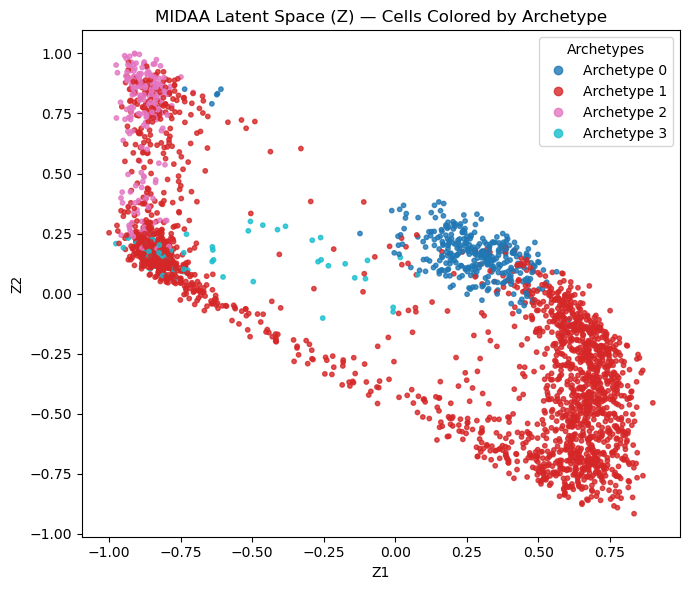

In [11]:
import numpy as np

def extract_mida_matrices(aa_result, input_matrix):
    iq = aa_result["inferred_quantities"]

    # A: (n_cells × n_archetypes)
    A = iq["A"]

    # Z: latent representation (n_cells × latent_dim)
    Z = iq["Z"]

    # B: archetype positions in latent space (n_archetypes × latent_dim)
    B = iq["B"]

    # archetypes_inferred: gene weights for each archetype
    # shape: (n_genes, n_archetypes)
    C = iq["archetypes_inferred"]

    # X: original input data
    X = input_matrix[0]   # (n_cells × n_genes)

    # Labels = archetype with highest membership
    labels = np.argmax(A, axis=1)

    return A, B, Z, C, X, labels

A, B, Z, C, X, labels = extract_mida_matrices(aa_result, input_matrix)

print("A (memberships):", A.shape)
print("B (latent archetype coords):", B.shape)
print("Z (latent cells):", Z.shape)
print("C (gene weights):", C.shape)
print("X (input data):", X.shape)
print("labels:", labels.shape)

import torch

# Save   three core MIDAA matrices
torch.save(
    {'A': A, 'B': B, 'C': C},
    "midaa_core_matrices.pth"
)

print("Saved A, B, C matrices to midaa_core_matrices.pth")


import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 6))

scatter = plt.scatter(
    Z[:, 0], Z[:, 1],
    c=labels,
    s=10,
    cmap="tab10",       # better for discrete clusters
    alpha=0.8
)

plt.title("MIDAA Latent Space (Z) — Cells Colored by Archetype")
plt.xlabel("Z1")
plt.ylabel("Z2")

# Create legend for 4 archetypes
handles, _ = scatter.legend_elements()
plt.legend(handles, [f"Archetype {i}" for i in range(4)], title="Archetypes")

plt.tight_layout()
plt.show()

